Classifying Spectra with Convolutional Neural Networks (CNNs)
===



Author: Nathan A. Mahynski
    
Date: 2024/08/02
    
Description: Examples of how to classify 1D spectra and 2D "images" using explainable CNNs.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/cnn_spectral_classification.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries    

In [2]:
if 'google.colab' in str(get_ipython()):
    # On Colab, check if runtime is attached to a GPU and install a GPU version of tensorflow if available
    try:
        import subprocess, os
        subprocess.run(["nvidia-smi"]) 
    except FileNotFoundError:
        pass # No GPU is present
    else:
        !pip install tensorflow[and-cuda]==2.14.0
        os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries 

In [4]:
# Check for presence of a GPU and list, if using
import tensorflow
tensorflow.config.list_physical_devices('GPU')

In [5]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import watermark
import shap
import keras

import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from pyts.image import GramianAngularField
from pychemauth import utils
from pychemauth.datasets import make_pgaa_images, load_pgaa
from pychemauth.classifier.cnn import CNNFactory
from pychemauth.analysis.explain import CAM2D, color_series, bokeh_color_spectrum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%load_ext watermark

%load_ext autoreload
%autoreload 2

In [6]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.26.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 6.5.0-45-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

keras     : 2.14.0
matplotlib: 3.7.2
watermark : 2.4.3
pychemauth: 0.0.0b4
numpy     : 1.26.4
json      : 2.0.9
shap      : 0.45.1
tensorflow: 2.14.0



1D CNN
---

<h3>Load Data</h3>

In [7]:
# Let's look at the data over this range of bins.
valid_range=(0, 2631)

In [8]:
# Load the dataset, clip, then renormalize
X, y = load_pgaa(return_X_y=True)
X = X[:, valid_range[0] : valid_range[1]]
X = (X.T / np.sum(X, axis=1)).T
X = np.log(np.clip(X, a_min=1.0e-7, a_max=None))

# Also convert X into a "single channeled image" with shape (2631, 2631, 1)
X = np.expand_dims(X, axis=-1)

# Exclude minor components - these have < 10 observations in the dataset
mask = np.array([False]*X.shape[0])
for class_ in ['Carbon Powder', 'Phosphate Rock', 'Zircaloy']:
    mask = mask | (y == class_)
X = X[~mask]
y = y[~mask]

# Split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y,
)

# Convert classes from strings to integers
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Record some basic properties about this revised dataset
image_size = (valid_range[1]-valid_range[0], 1)
n_classes = len(np.unique(y))

In [9]:
# Let's write the dataset to disk so we can create data iterators later on
from pychemauth.utils import write_dataset
_ = write_dataset('./1d-dataset/train', X_train, y_train, overwrite=True, augment=False)
_ = write_dataset('./1d-dataset/test', X_test, y_test, overwrite=True, augment=False)

<h3>Learning Rate Finder</h3>

In [10]:
def make_model(image_size, n_classes, activation='relu'):
    input_ = keras.layers.Input(shape=image_size)
    conv1 = layers.Conv1D(filters=16, kernel_size=16, activation=activation, strides=8, padding='same', use_bias=True)(input_)
    pool1 = layers.MaxPool1D(2)(conv1)
    conv2 = layers.Conv1D(filters=16*8, kernel_size=8, activation=activation, strides=4, padding='same', use_bias=True)(pool1)
    pool2 = layers.MaxPool1D(2)(conv2)
    conv3 = layers.Conv1D(filters=16*8*4, kernel_size=8, activation=activation, strides=2, padding='same', use_bias=True)(pool2)
    flat = layers.Flatten()(conv3)
    output = layers.Dense(n_classes, activation='softmax')(flat)
    model = keras.Model(inputs=[input_], outputs=[output])
    
    return model

/home/nam4/anaconda3/envs/k3test/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


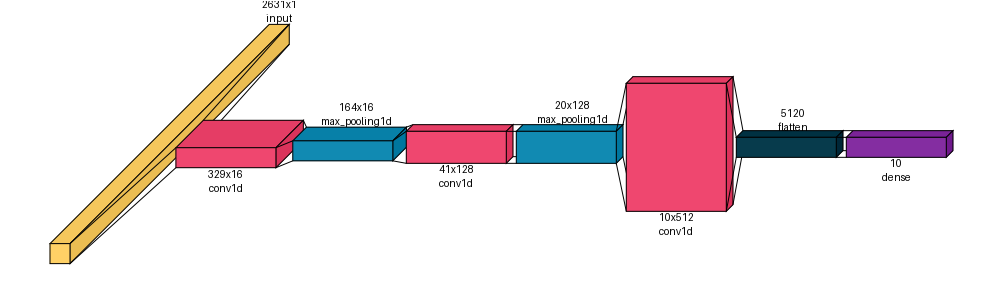

In [11]:
utils.NNTools.visualkeras(make_model(image_size, n_classes=n_classes, activation='elu'), max_z=100)

In [12]:
data_loader = utils.NNTools.build_loader('./1d-dataset/train', batch_size=100, shuffle=True)
finder = utils.NNTools.find_learning_rate(
    make_model(image_size, n_classes=n_classes, activation='elu'),
    data_loader,
    start_lr=1.0e-6,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 129ms/step


Epoch 1/42
3/3 [==============================] - 1s 37ms/step - loss: 2.8172 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 2/42
3/3 [==============================] - 0s 37ms/step - loss: 2.7713 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 3/42
3/3 [==============================] - 0s 34ms/step - loss: 2.7125 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 4/42
3/3 [==============================] - 0s 29ms/step - loss: 2.6320 - accuracy: 0.0500 - sparse_categorical_accuracy: 0.0500
Epoch 5/42
3/3 [==============================] - 0s 30ms/step - loss: 2.5261 - accuracy: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6/42
3/3 [==============================] - 0s 29ms/step - loss: 2.4053 - accuracy: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7/42
3/3 [==============================] - 0s 30ms/step - loss: 2.3543 - accuracy: 0.0811 - sparse_categorical_accuracy: 0.0811
Epoch 8/42
3/3 [=======================

In [13]:
# Observe that x and y are shuffled
data_loader.x[:3]

['/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000223.npy',
 '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000000.npy',
 '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000061.npy']

In [14]:
# Compare the data loader's first 3 y values...
data_loader.y[:3]

array([6, 7, 7])

In [15]:
# ... to the original y with indices corresponding to the x files.
y_train[223], y_train[0], y_train[61]

(6, 7, 7)

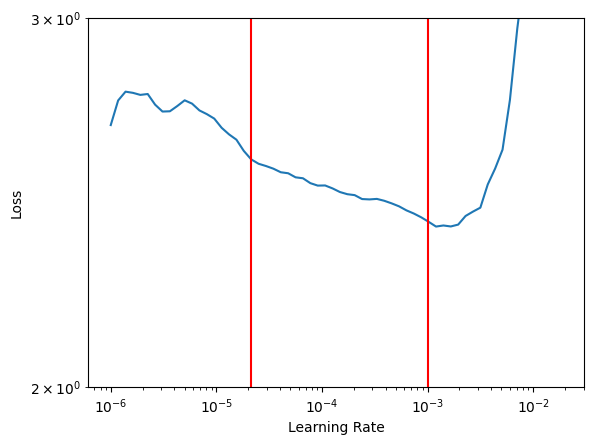

In [16]:
# Let's see if we can establish a reasoble range of learning rates so we can use cyclical learning rates when training
ax = finder.plot()
ax.set_yscale('log')

frac = 0.5

ax.set_ylim(2, 3)
for l_ in finder.estimate_clr(frac=frac):
    ax.axvline(l_, color='red')

<h3>Cyclical Learning Rates</h3>

In [17]:
def fit_model(image_size, finder, n_classes, use_clr=False, wandb_project=None, mode='triangular'):
    """Convenient function to train models several times with different hyperparameters."""
    clr = utils.NNTools.CyclicalLearningRate(
        base_lr=finder.estimate_clr(frac=frac)[0],
        max_lr=finder.estimate_clr(frac=frac)[1],
        step_size=10, # 1/2 cycle every 10 epochs
        mode=mode,
    )

    # Build a fresh model
    model = make_model(image_size, n_classes=n_classes, activation='relu')

    # Build a data loader
    data_loader = utils.NNTools.build_loader('./1d-dataset/train', batch_size=100, shuffle=True)
    
    # Do the training
    model = utils.NNTools.train(
        model=model,
        data=data_loader, 
        fit_kwargs={
            'epochs': 60, # (10*2) = 20 epochs for a cycle, so this is 3 cycles
            'validation_data': utils.NNTools.build_loader('./1d-dataset/test', batch_size=100), # Shuffling doesn't matter here
            'callbacks': [clr] if use_clr else []
        },
        model_filename=None, # Do not save locally
        history_filename=None, # Do not save locally
        wandb_project=wandb_project,
        seed=42
    )
    
    return model, clr, data_loader

def plot_results(model, clr=None):
    """Convenient function to plot results locally - you can see the same results on WandB."""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    for ax in axes:
        ax.set_xlabel('Epoch')
    
    if clr is not None:
        axes[0].plot(
            clr.history['iterations'],
            clr.history['lr']
        )
    else:
        axes[0].axhline(float(model.optimizer.lr))
    axes[0].set_ylabel('Learning Rate')
    axes[0].set_yscale('log')

    axes[1].plot(model.history.history['accuracy'], label='Accuracy')
    axes[1].plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='best')

    axes[2].plot(model.history.history['loss'], label='Loss')
    axes[2].plot(model.history.history['val_loss'], label='Validation Loss')
    axes[2].set_ylabel('Loss')
    axes[2].legend(loc='best')

In [20]:
# Let's try several different CLR strategies to compare them.
# Visit wandb.com to look at the new runs stored in the 'cnn-1d-demo' project!
model_none, _, dl_none = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=False, 
    wandb_project='cnn-1d-demo'
)

model_clr, clr, dl = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=True, 
    wandb_project='cnn-1d-demo', 
    mode='triangular'
)

model_clr2, clr2, dl2 = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=True, 
    wandb_project='cnn-1d-demo', 
    mode='triangular2'
)

In [19]:
# The same seed is given to Keras and same number of epochs are performed so data shuffling is the same
dl_none.x[:3], dl.x[:3], dl2.x[:3]

(['/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000161.npy'],
 ['/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000161.npy'],
 ['/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000161.npy'])

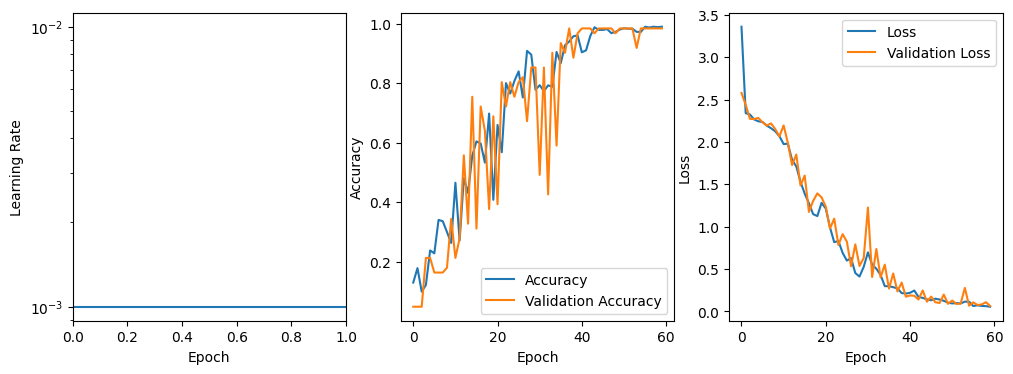

In [21]:
# We can view the results directly
plot_results(model_none)

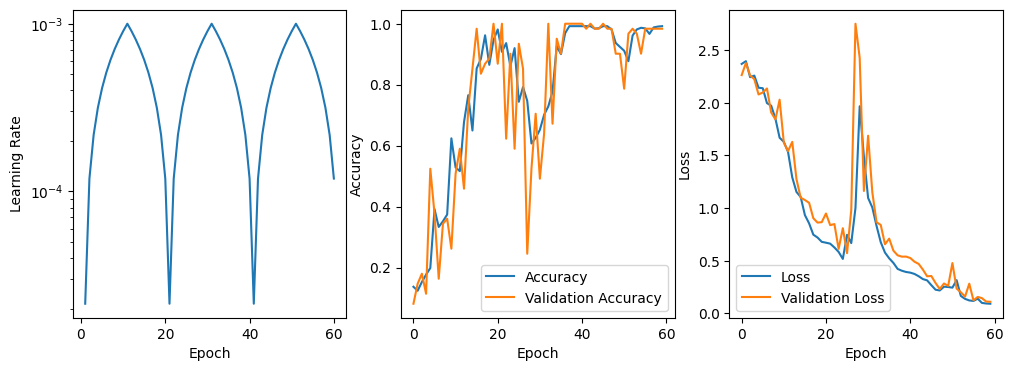

In [22]:
plot_results(model_clr, clr)

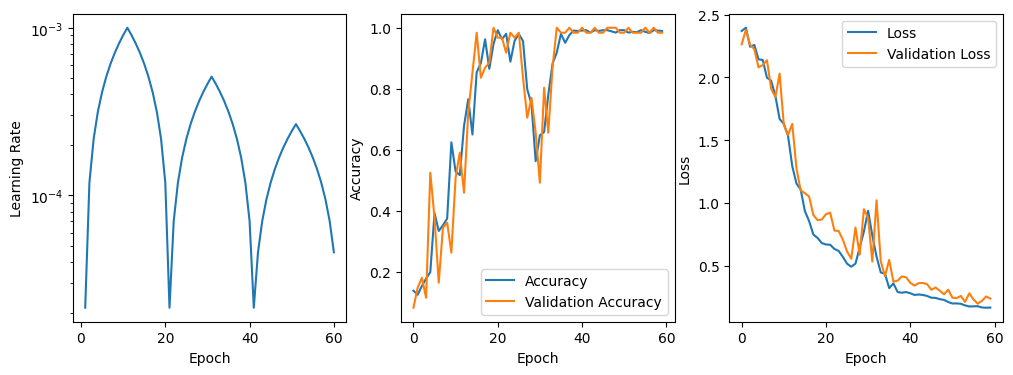

In [23]:
plot_results(model_clr2, clr2)

2D CNN
---

<h3>Load Data</h3>

In [24]:
# Let's build 2D "images" of these spectra with the same preprocessing as above
res = make_pgaa_images(
    transformer=GramianAngularField(method='difference'), 
    exclude_classes=['Carbon Powder', 'Phosphate Rock', 'Zircaloy'], 
    directory='./2d-dataset', 
    overwrite=True, 
    fmt='npy', 
    valid_range=valid_range, 
    renormalize=True,
    test_size=0.2,
    random_state=42
)

Transforming test set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.52it/s]


In [25]:
# We will use the label encoder for nicer visualization later on
encoder = res[-1]

<h3>Learning Rate Finder</h3>

In [26]:
# Let's use the CNNFactory in PyChemAuth to build a model for transfer learning

image_size = (valid_range[1]-valid_range[0], valid_range[1]-valid_range[0], 1)
n_classes = 10

cnn_builder = CNNFactory(
    name='mobilenet', # Name of the "fixed" base we will use (trained on imagenet)
    input_size=image_size,
    n_classes=n_classes,
    dim=2,
    cam=True,
    dropout=0.2
) 

In [27]:
# Let's look at a basic summary of this model
model = cnn_builder.build()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 2631, 2631, 3)     3         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 2631, 2631, 3)     0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 2631, 2631, 3)     0         
 da)                                                             
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228864   
 onal)                                                           
                                                           

/home/nam4/anaconda3/envs/k3test/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


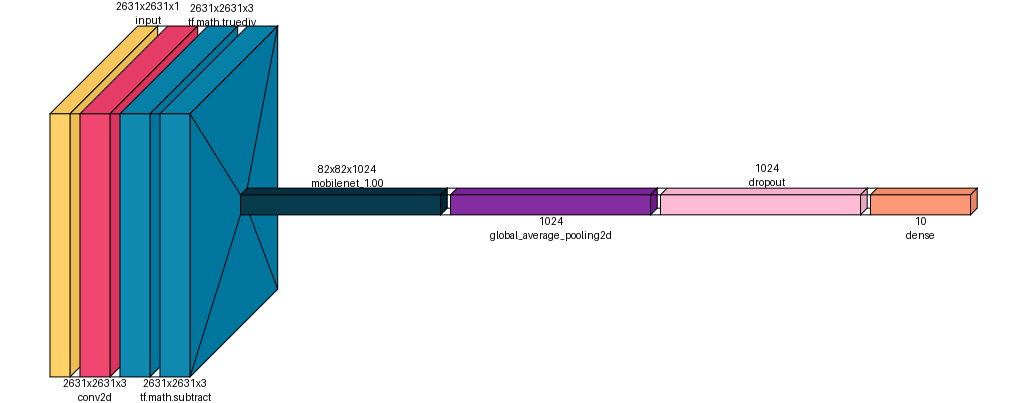

In [28]:
# We can also visualize the model another way
utils.NNTools.visualkeras(model, scale_xy=0.1, max_z=200)

In [29]:
# Now let's search for learning rate bounds
finder = utils.NNTools.find_learning_rate(
    cnn_builder.build(),
    pychemauth.utils.NNTools.build_loader('./2d-dataset/train/', batch_size=10),
    start_lr=1.0e-6,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [

1/1 [==============================] - 1s 1s/step
Epoch 1/5


2024-08-06 14:23:03.612646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4433551360 exceeds 10% of free system memory.
2024-08-06 14:23:04.006560: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4440291840 exceeds 10% of free system memory.


 1/25 [>.............................] - ETA: 3:59 - loss: 3.6330 - accuracy: 0.0648 - sparse_categorical_accuracy: 0.0648

2024-08-06 14:23:11.842287: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4433551360 exceeds 10% of free system memory.
2024-08-06 14:23:12.270542: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4440291840 exceeds 10% of free system memory.


 2/25 [=>............................] - ETA: 3:10 - loss: 3.8195 - accuracy: 0.0614 - sparse_categorical_accuracy: 0.0614

2024-08-06 14:23:20.116812: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4433551360 exceeds 10% of free system memory.


25/25 [==============================] - 204s 8s/step - loss: 3.5480 - accuracy: 0.0986 - sparse_categorical_accuracy: 0.0986
Epoch 2/5
25/25 [==============================] - 204s 8s/step - loss: 3.2099 - accuracy: 0.0866 - sparse_categorical_accuracy: 0.0866
Epoch 3/5
25/25 [==============================] - 207s 8s/step - loss: 4.0649 - accuracy: 0.1175 - sparse_categorical_accuracy: 0.1175
Epoch 4/5
25/25 [==============================] - 137s 5s/step - loss: 54.6713 - accuracy: 0.1315 - sparse_categorical_accuracy: 0.1315


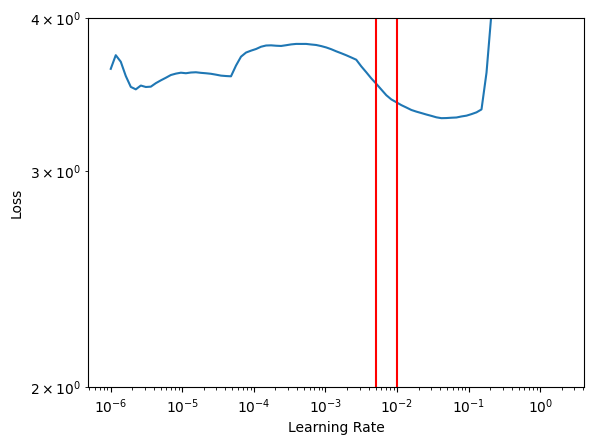

In [31]:
# "frac" can be adjusted to control the left / lower bound on the learning rate
# Adjust this until you are satisfied - we will use it next
frac = 0.9

ax = finder.plot()
ax.set_yscale('log')
ax.set_ylim(2,4)
for l_ in finder.estimate_clr(frac=frac):
    ax.axvline(l_, color='red')

<h3>Cyclical Learning Rates</h3>

In [32]:
def fit_model(image_size, finder, use_clr=False, wandb_project=None, mode='triangular'):
    """Convenient function to train models several times with different hyperparameters."""
    clr = utils.NNTools.CyclicalLearningRate(
        base_lr=finder.estimate_clr(frac=frac)[0],
        max_lr=finder.estimate_clr(frac=frac)[1],
        step_size=10, # 1/2 cycle every 10 epochs
        mode=mode,
    )

    model = cnn_builder.build()

    data_loader = utils.NNTools.build_loader('./2d-dataset/train', batch_size=10, shuffle=True)
    
    model = utils.NNTools.train(
        model=model,
        data=data_loader, 
        fit_kwargs={
            'epochs': 60,
            'validation_data': utils.NNTools.build_loader('./2d-dataset/test', batch_size=10),
            'shuffle': True,
            'callbacks': [clr] if use_clr else []
        },
        model_filename=None,
        history_filename=None,
        wandb_project=wandb_project,
        seed=42
    )
    
    return model, clr, data_loader

In [33]:
# Fit the model and track the training on WandB
model, clr, dl = fit_model(
    image_size,
    finder,
    use_clr=True, 
    wandb_project='cnn-2d-demo',
    mode='triangular2'
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [

1/1 [==============================] - 1s 1s/step


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch/accuracy,▁▁▂▂▃▃▄▄▅▆▇▇▇██▇██▆▅▅▅▇█████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▂▂▄▄▆▇█▇▆▅▄▂▂▁▂▂▃▃▄▄▄▄▃▂▂▁▁▁▂▂▂▂▃▃▂▂▂▂▁▁
batch/loss,███▇▆▇▅▅▅▄▃▃▃▃▃▃▂▂▂▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/sparse_categorical_accuracy,▁▁▂▂▃▃▄▄▅▆▇▇▇██▇██▆▅▅▅▇█████████████████
epoch/accuracy,▁▁▁▂▃▃▅▄▅▆▇▇▇█████▆▆▅▅▇▇████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▂▂▄▄▆▇█▇▆▅▄▃▂▁▂▂▃▃▄▄▄▄▃▃▂▂▁▁▂▂▂▂▃▃▂▂▂▂▁▁
epoch/loss,███▇▇▇▆▆▅▄▃▃▃▃▃▂▂▂▂▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▂▃▃▅▄▅▆▇▇▇█████▆▆▅▅▇▇████████████████
epoch/val_accuracy,▁▂▁▄▂▃▂▄▄▆█▇▇██▇██▆▆▄▆▇█████████████████


Epoch 1/60
25/25 [==============================] - 259s 10s/step - loss: 3.2780 - accuracy: 0.0781 - sparse_categorical_accuracy: 0.0781 - val_loss: 1.9623 - val_accuracy: 0.3279 - val_sparse_categorical_accuracy: 0.3279
Epoch 2/60
25/25 [==============================] - 258s 10s/step - loss: 2.7194 - accuracy: 0.1847 - sparse_categorical_accuracy: 0.1847 - val_loss: 2.1303 - val_accuracy: 0.1803 - val_sparse_categorical_accuracy: 0.1803
Epoch 3/60
25/25 [==============================] - 260s 10s/step - loss: 2.4682 - accuracy: 0.2188 - sparse_categorical_accuracy: 0.2188 - val_loss: 2.0993 - val_accuracy: 0.3279 - val_sparse_categorical_accuracy: 0.3279
Epoch 4/60
25/25 [==============================] - 262s 11s/step - loss: 2.5904 - accuracy: 0.2004 - sparse_categorical_accuracy: 0.2004 - val_loss: 2.6651 - val_accuracy: 0.0820 - val_sparse_categorical_accuracy: 0.0820
Epoch 5/60
25/25 [==============================] - 262s 11s/step - loss: 2.2164 - accuracy: 0.2645 - sparse_cat

Epoch 38/60
25/25 [==============================] - 279s 11s/step - loss: 0.9821 - accuracy: 0.6341 - sparse_categorical_accuracy: 0.6341 - val_loss: 0.8750 - val_accuracy: 0.7377 - val_sparse_categorical_accuracy: 0.7377
Epoch 39/60
25/25 [==============================] - 279s 11s/step - loss: 0.9800 - accuracy: 0.6324 - sparse_categorical_accuracy: 0.6324 - val_loss: 0.9741 - val_accuracy: 0.5902 - val_sparse_categorical_accuracy: 0.5902
Epoch 40/60
25/25 [==============================] - 279s 11s/step - loss: 0.9823 - accuracy: 0.6189 - sparse_categorical_accuracy: 0.6189 - val_loss: 0.8241 - val_accuracy: 0.6066 - val_sparse_categorical_accuracy: 0.6066
Epoch 41/60
25/25 [==============================] - 278s 11s/step - loss: 1.0484 - accuracy: 0.6043 - sparse_categorical_accuracy: 0.6043 - val_loss: 1.2765 - val_accuracy: 0.5902 - val_sparse_categorical_accuracy: 0.5902
Epoch 42/60
25/25 [==============================] - 278s 11s/step - loss: 1.2878 - accuracy: 0.5632 - spars

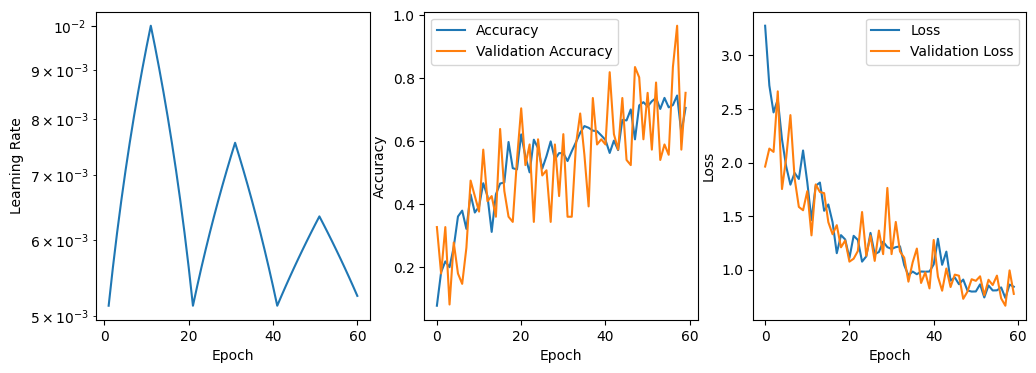

In [34]:
# Look at the results locally
plot_results(model, clr)

In [52]:
# Save the result to HuggingFace
_ = utils.HuggingFace.push_to_hub(
    model=model,
    namespace="mahynski", # Insert your own namespace here
    repo_name="2d-cnn-demo", # You can change the name if you like
    token="hf_*", # Insert your own token here
    private=False
)

model.pkl:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

In [53]:
# Load the model back from HuggingFace for comparison
hf_model = utils.HuggingFace.from_pretrained(
    model_id="mahynski/2d-cnn-demo",
)

model.pkl:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

In [54]:
# Confirm the models make the same predictions
preds = model.predict(utils.NNTools.build_loader('./2d-dataset/test', batch_size=10))
preds_hf = hf_model.predict(utils.NNTools.build_loader('./2d-dataset/test', batch_size=10))

np.allclose(preds, preds_hf)

7/7 [==============================] - 57s 8s/step


True

Explanations
---

<h3>Class Activation Maps (CAMs)</h3>

In [55]:
# We can use a CAM explainer to visually explain each prediction
explainer = CAM2D(style='hires')

In [56]:
# Load 2D data (and 1D for visualization reasons)
data_loader_2d = utils.NNTools.build_loader('./2d-dataset/test', batch_size=10)
data_loader_1d = utils.NNTools.build_loader('./1d-dataset/test', batch_size=10)

In [57]:
def explain(batch_idx, idx_in_batch):
    """Explain predictions from a certain batch."""
    X_batch, y_batch = data_loader_2d[batch_idx]
    X, y = X_batch[idx_in_batch], y_batch[idx_in_batch]

    X_batch, y_batch = data_loader_1d[batch_idx]
    X_line, y_line = X_batch[idx_in_batch], y_batch[idx_in_batch]
    
    explainer.visualize(
        image=X,
        model=hf_model,
        y=X_line.ravel(),
        x=np.arange(X_line.shape[0]),
        correct_label=encoder.inverse_transform([y])[0],
        origin='upper',
        encoder=encoder
    )

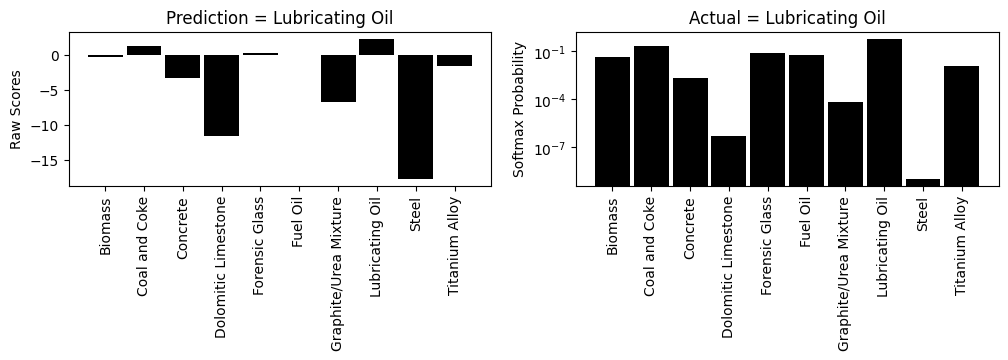

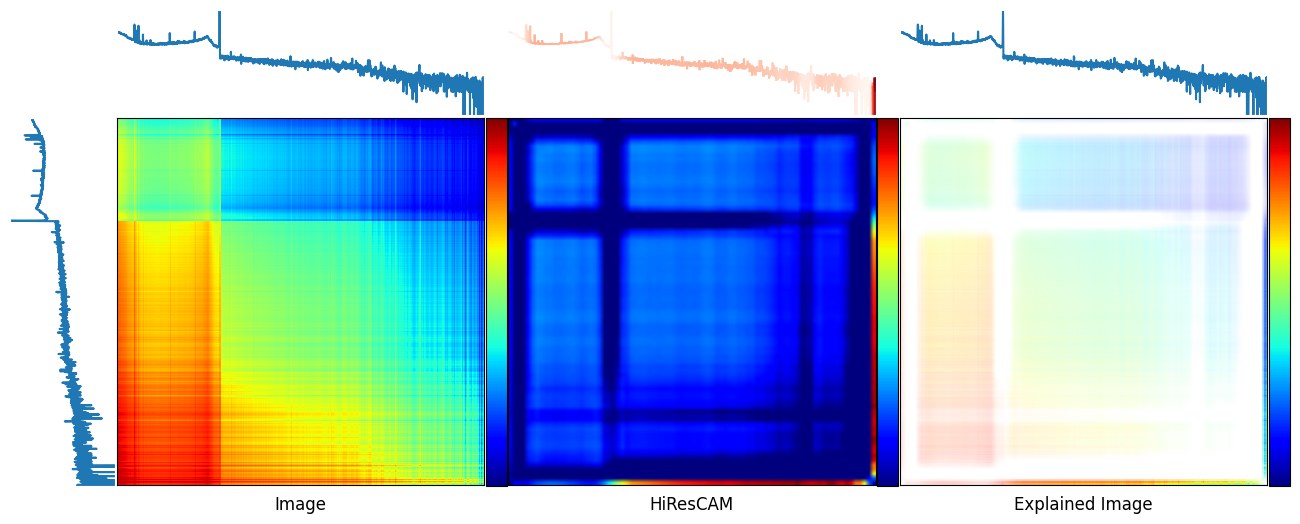

In [58]:
explain(0, 0)

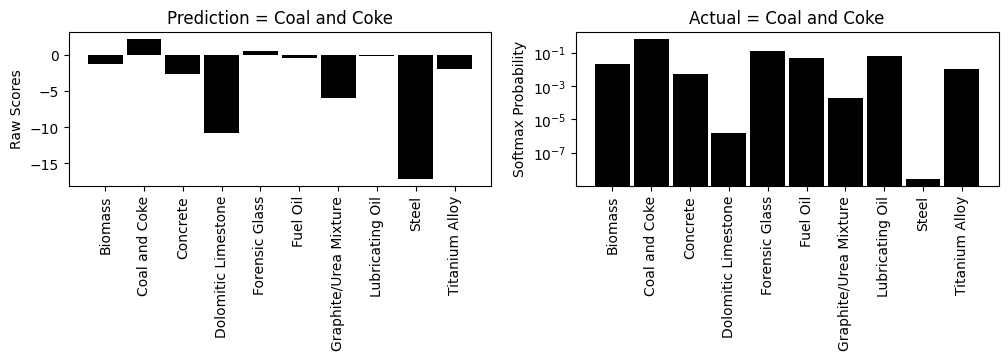

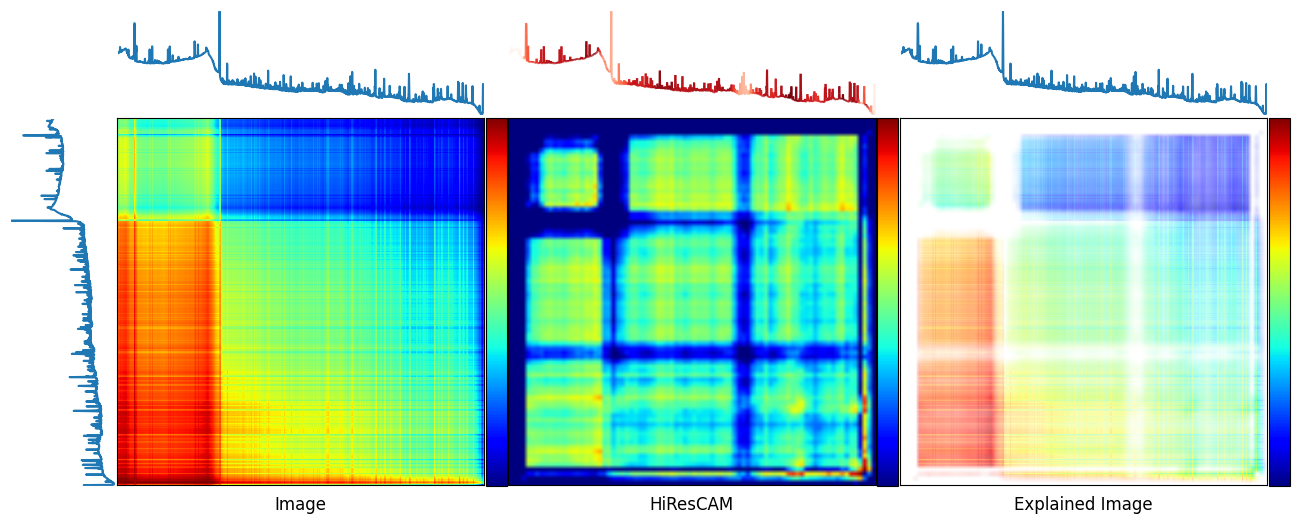

In [59]:
explain(0, 1)

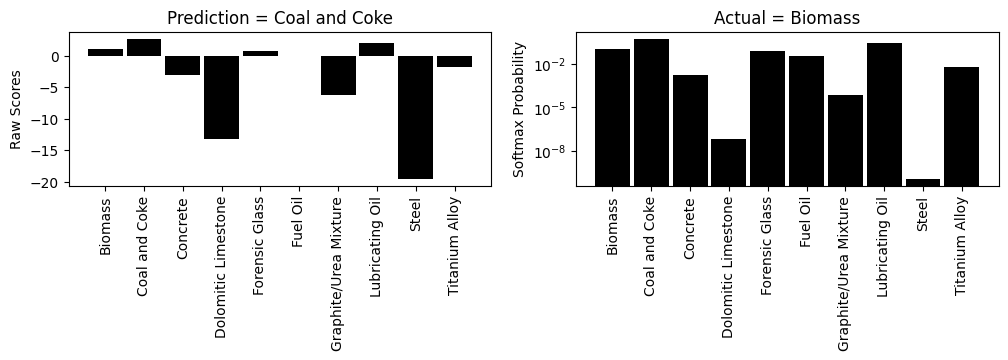

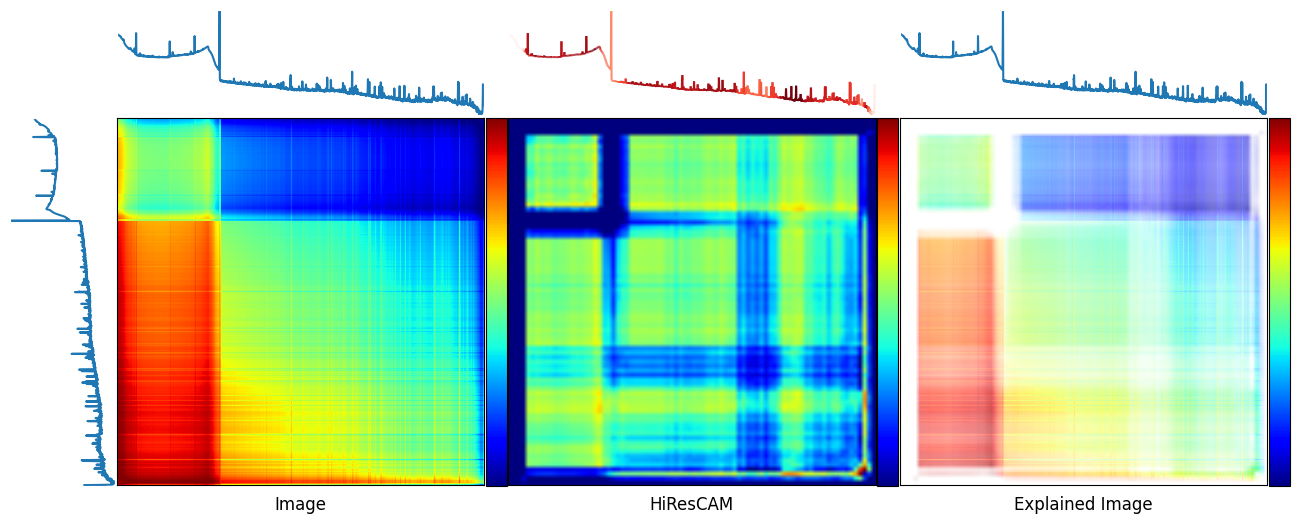

In [60]:
explain(0, 2)

<h3>Manual Inspection in 1D</h3>

In [79]:
# Sometimes we might want to take a closer look and interactively explore an explanation, especially in 1D
# Here is a way to do that using Bokeh for interactive visualization.

importances = explainer.importances(
    image=data_loader_2d[0][0][1],
    model=hf_model,
    symmetrize=True,
    dim=1, # Get a 1D summary of the 2D explanation
    series_summary='mean'
)

peaks = data_loader_1d[0][0][1]

In [80]:
from bokeh.io import output_notebook
output_notebook()

bokeh_color_spectrum(
    y=peaks,
    x=np.arange(peaks.shape[0]),
    importance_values=importances
)

Loading BokehJS ...

<h3>SHAP</h3>

This explanation relies on the "partition" explainer by "blurring" pixels to create "super pixels".  See [here](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html) for more details.

In [81]:
# Remember the model's properties - specifically, the "image" shape coming out of the pretrained CNN base
hf_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2631, 2631, 3)     3         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 2631, 2631, 3)     0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 2631, 2631, 3)     0         
 mbda)                                                           
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228864   
 onal)                                                           
                                                           

In [82]:
# Blur the input to about the same size as the output from the CNN base (here: (82, 82))
blur_size = hf_model.layers[-3].input_shape[1:3]

# Define a masker that is used to mask out partitions of the input image creating partitions.
# This is not strictly necessary (size can be arbitrary) but this way we can more fairly compare these
# explanations with those from CAM.
masker = shap.maskers.Image(f"blur{blur_size}", image_size)

# create an explainer with model and image masker
explainer = shap.Explainer(
    hf_model.predict,
    masker=masker, 
    output_names=encoder.classes_,
    algorithm="partition"
)

In [83]:
# Let's select the same points we did with CAM
X, y = data_loader_2d[0]

In [84]:
# The correct answers
encoder.inverse_transform(y[:3])

array(['Lubricating Oil', 'Coal and Coke', 'Biomass'], dtype=object)

In [85]:
# Explain these first 3 predictions - the "argsort" is a simple way to retrieve the top 4 most likely predictions.
# Conveniently, these are provided with SHAP.  Although we can compute similar CAM maps, this is not typically done
# and PyChemAuth is not configured for this at the moment.
shap_values = explainer(
    X[:3], 
    max_evals=200, # This controls how "fine-grained" the resulting map is
    outputs=shap.Explanation.argsort.flip[:4]
)

1/1 [==============================] - 7s 7s/step


  0%|          | 0/198 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


PartitionExplainer explainer:  33%|███████████████████████████████████████████████████████▎                                                                                                              | 1/3 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


  0%|          | 0/198 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


PartitionExplainer explainer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:52<00:00, 103.43s/it]

1/1 [==============================] - 7s 7s/step


  0%|          | 0/198 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


PartitionExplainer explainer: 4it [10:19, 206.56s/it]                                                                                                                                                                          


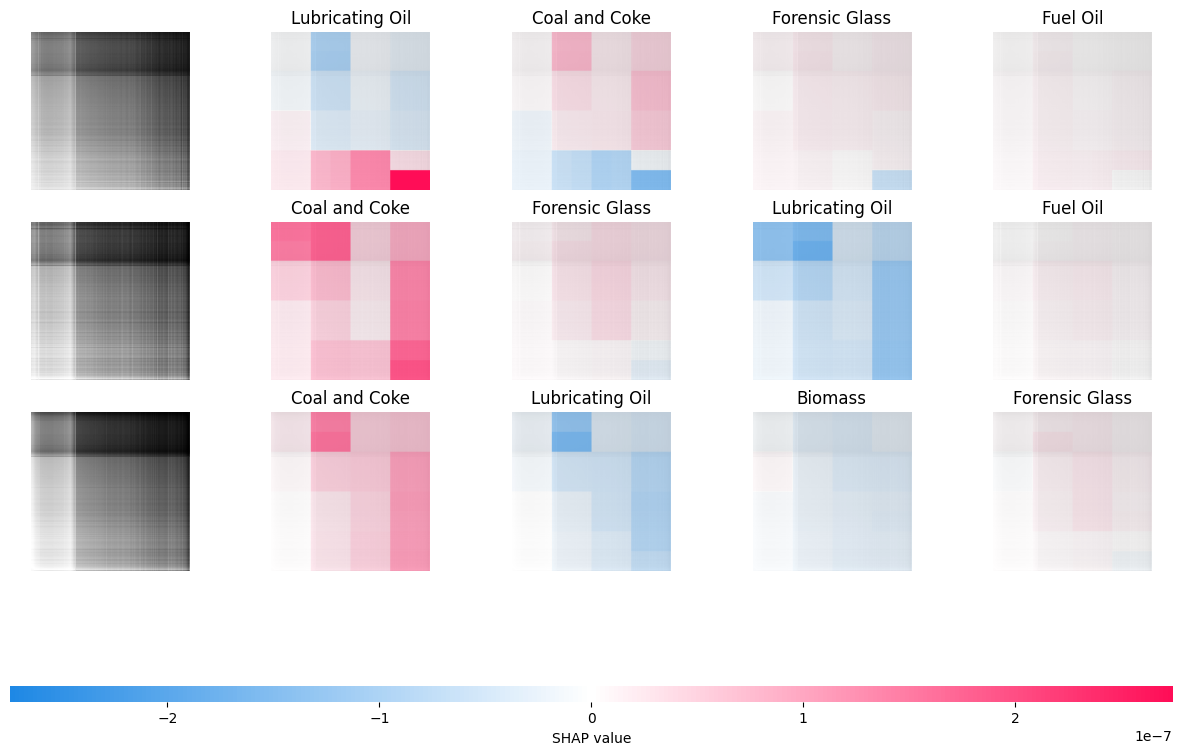

In [86]:
shap.image_plot(shap_values)